# Testing `causallib` plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Previous versions of causallib might produce lots of warnings when evaluating outcomes due to faulty argument passing
import warnings

warnings.filterwarnings("ignore")

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression

from causallib.datasets import load_nhefs
from causallib.estimation import AIPW, IPW, StratifiedStandardization
from causallib.evaluation import Evaluator, plots

In [4]:
data = load_nhefs()
data.X.head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361


## Testing propensity plots

In [5]:
propensity_plots = [
    "covariate_balance_love",
    "weight_distribution",
    "covariate_balance_slope",
    "calibration",
    "roc_curve",
    "pr_curve",
]

In [6]:
ipw = IPW(LogisticRegression(max_iter=2000), clip_min=0.05, clip_max=0.95)
ipw.fit(data.X, data.a, data.y)

IPW(clip_max=0.95, clip_min=0.05, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=2000))

In [7]:
propensity_evaluator = Evaluator(ipw)
results = propensity_evaluator.evaluate_cv(data.X, data.a, data.y)

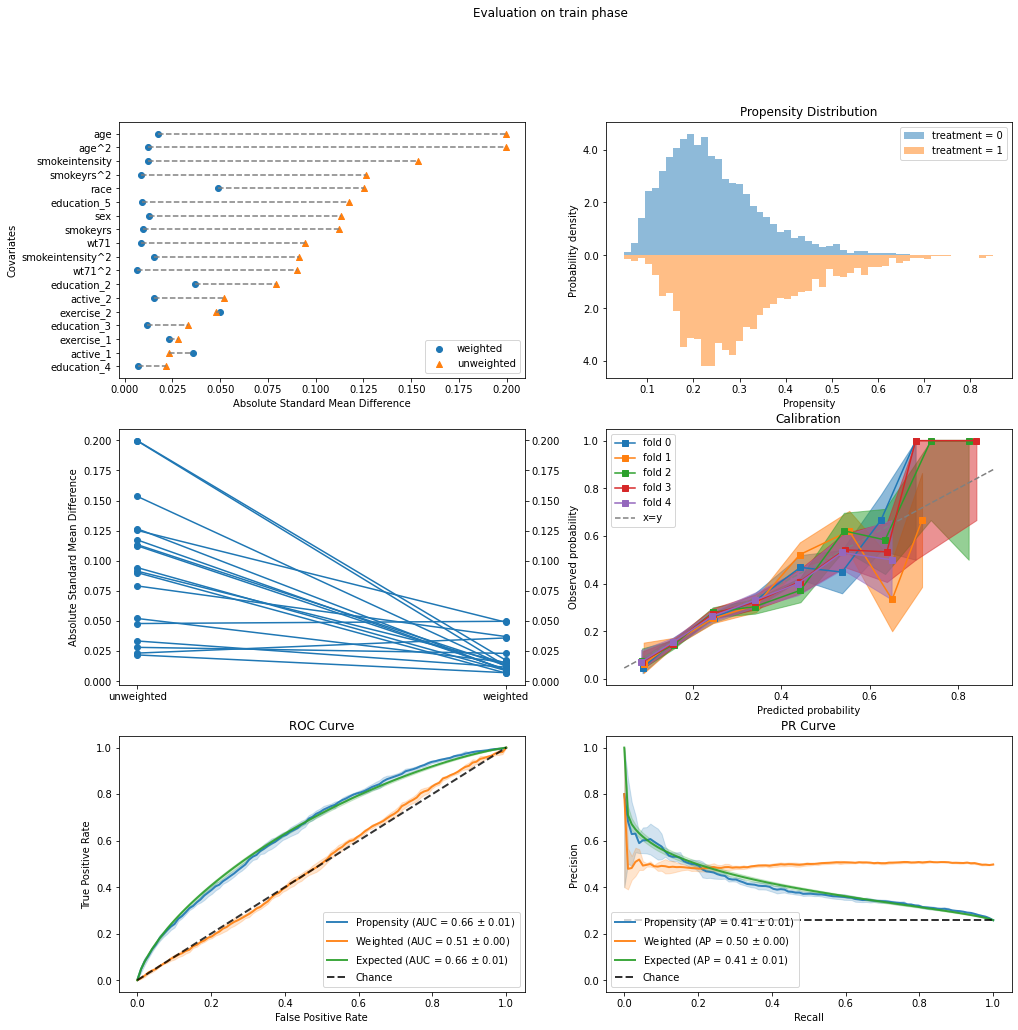

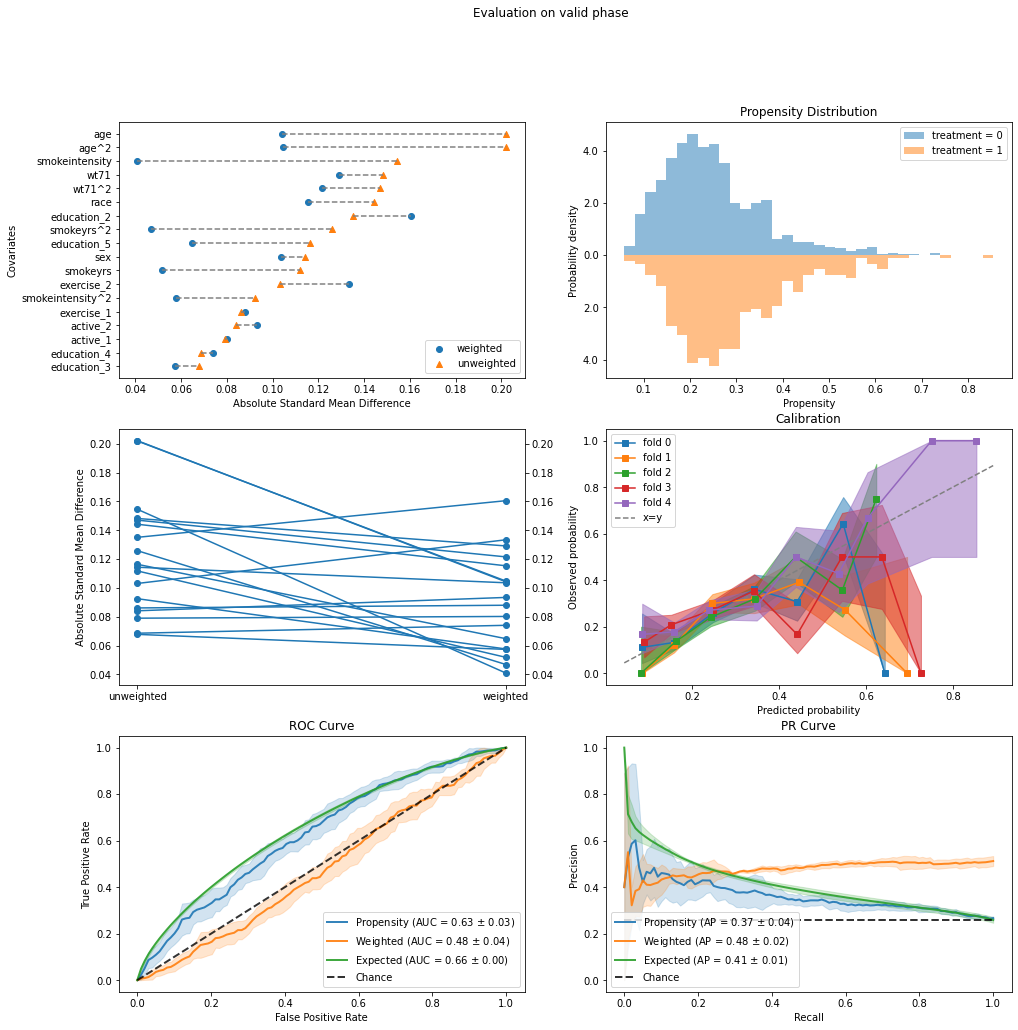

In [8]:
plot_axes = propensity_evaluator.plotter.plot_cv(
    X=data.X,
    a=data.a,
    y=data.y,
    predictions=results.predictions,
    cv=results.cv,
    plots=propensity_plots,
)

## Testing outcome plots

### Continuous outcomes

In [9]:
continuous_outcome_plots = [
    "continuous_accuracy",
    "common_support",
    "residuals",
]

In [10]:
cont_std = StratifiedStandardization(LinearRegression())
cont_std.fit(data.X, data.a, data.y)

StratifiedStandardization(learner=LinearRegression())

{'train': {'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>,
  'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>}}

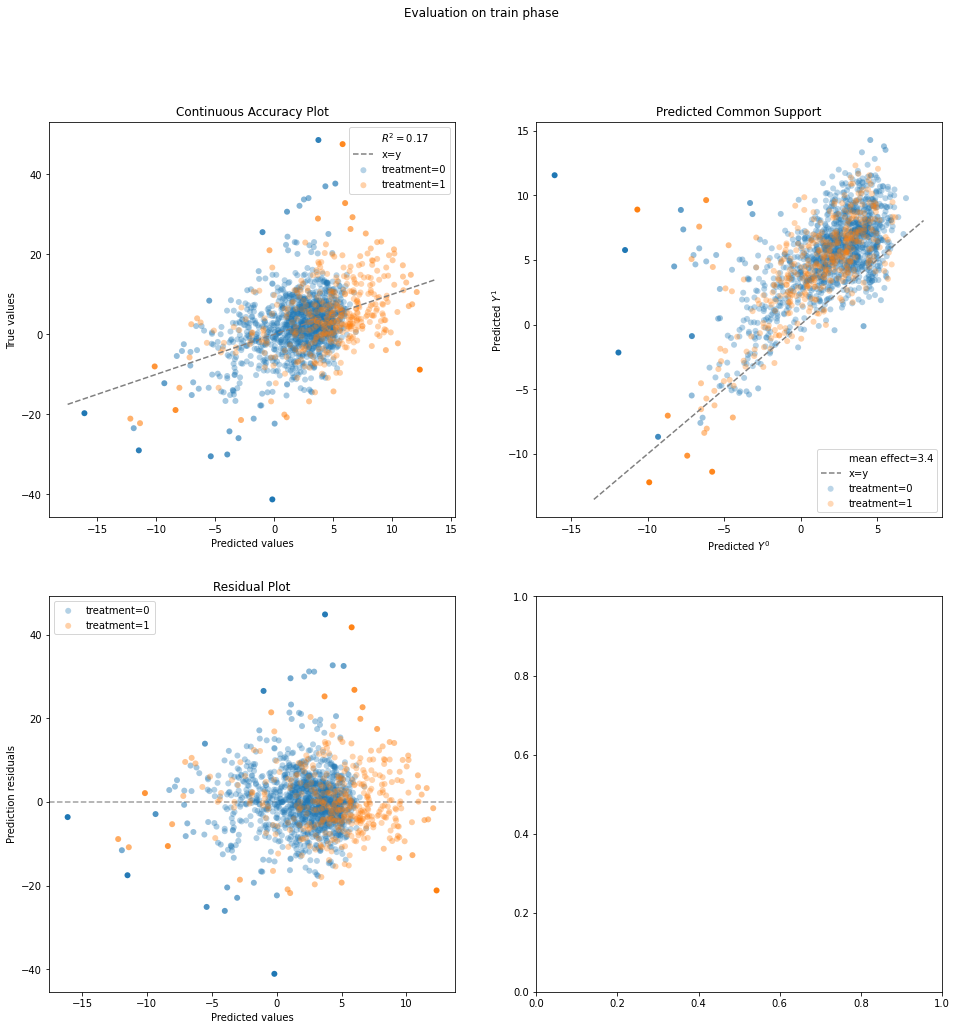

In [11]:
cont_outcome_evaluator = Evaluator(cont_std)
cont_outcome_results = cont_outcome_evaluator.evaluate_simple(
    data.X,
    data.a,
    data.y,
)
cont_outcome_evaluator.plotter.plot_cv(
    X=data.X,
    a=data.a,
    y=data.y,
    predictions=cont_outcome_results.predictions,
    cv=cont_outcome_results.cv,
    plots=continuous_outcome_plots,
)

### Binary outcomes

In [12]:
import numpy as np
import pandas as pd

In [13]:
binary_outcome_plots = [
    "calibration",
    "roc_curve",
    "pr_curve",
]

In [14]:
y = 1 / (1 + np.exp(-data.y))
y = np.random.binomial(1, y)
y = pd.Series(y, index=data.a.index)

In [15]:
bin_std = StratifiedStandardization(LogisticRegression(max_iter=2000))
bin_std.fit(data.X, data.a, y)

StratifiedStandardization(learner=LogisticRegression(max_iter=2000))

{'train': {'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>}}

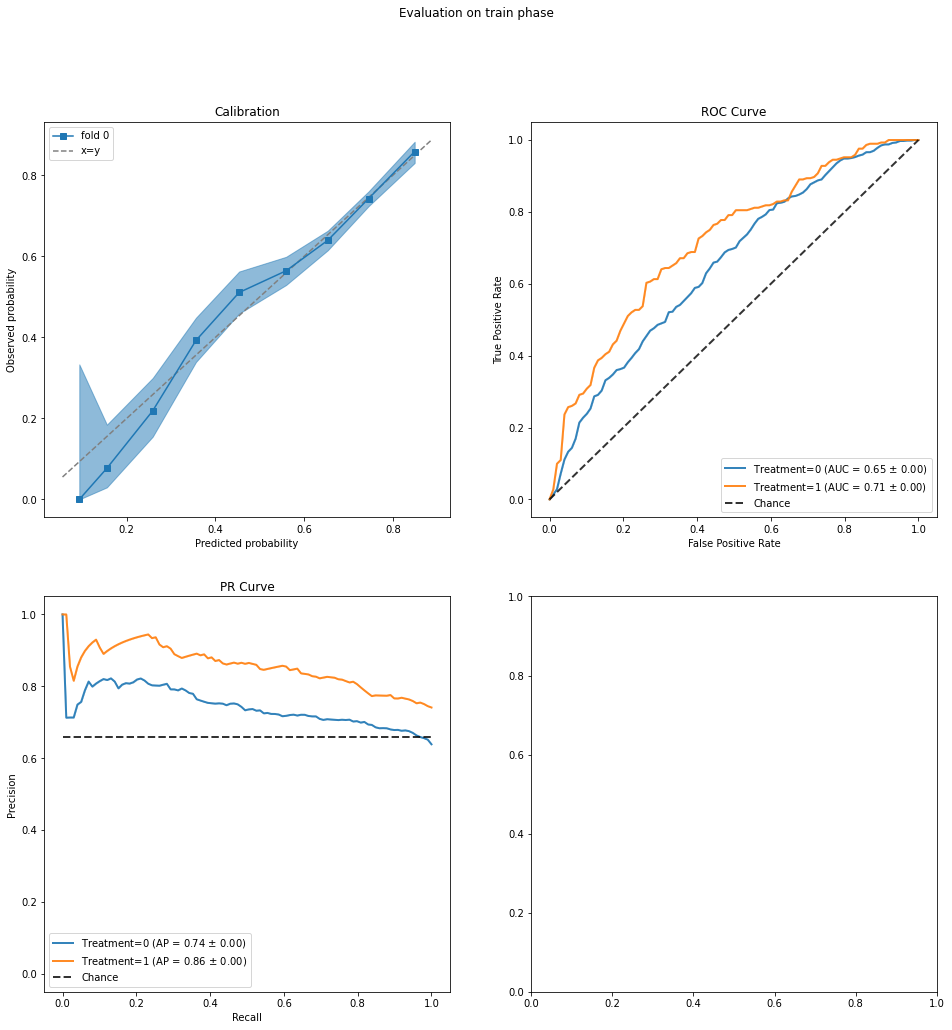

In [16]:
bin_outcome_evaluator = Evaluator(bin_std)
bin_outcome_results = bin_outcome_evaluator.evaluate_simple(
    data.X, data.a, y, metrics_to_evaluate=dict()
)
bin_outcome_evaluator.plotter.plot_cv(
    X=data.X,
    a=data.a,
    y=y,
    predictions=bin_outcome_results.predictions,
    cv=bin_outcome_results.cv,
    plots=binary_outcome_plots,
)

## Cross validation plotting

### IPW

{'train': {'covariate_balance_love': <AxesSubplot:xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>,
  'weight_distribution': <AxesSubplot:title={'center':'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,
  'covariate_balance_slope': <AxesSubplot:ylabel='Absolute Standard Mean Difference'>,
  'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>},
 'valid': {'covariate_balance_love': <AxesSubplot:xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>,
  'weight_distribution': <AxesSubplot:title={'center':'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,
  'covariate_balance_slope': <AxesSubplot:ylabel='Absolute Standard Mean D

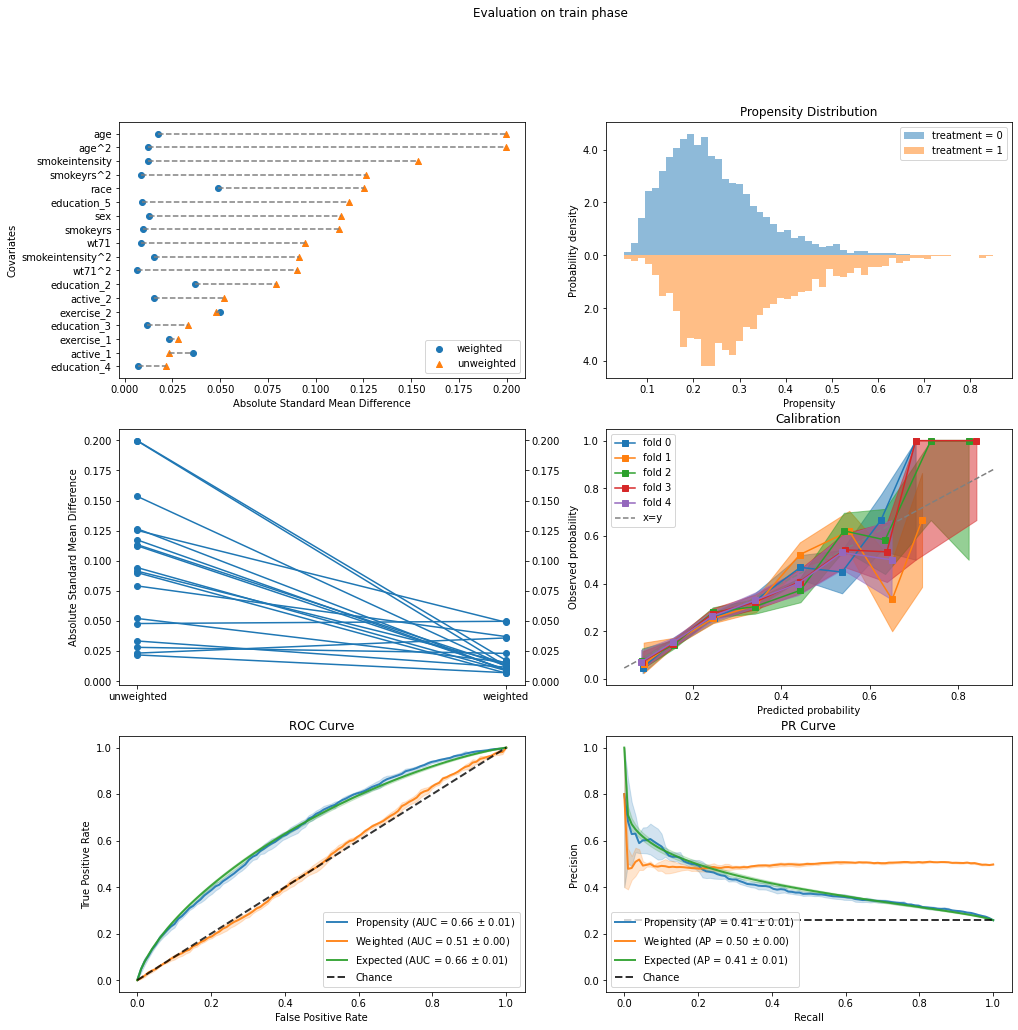

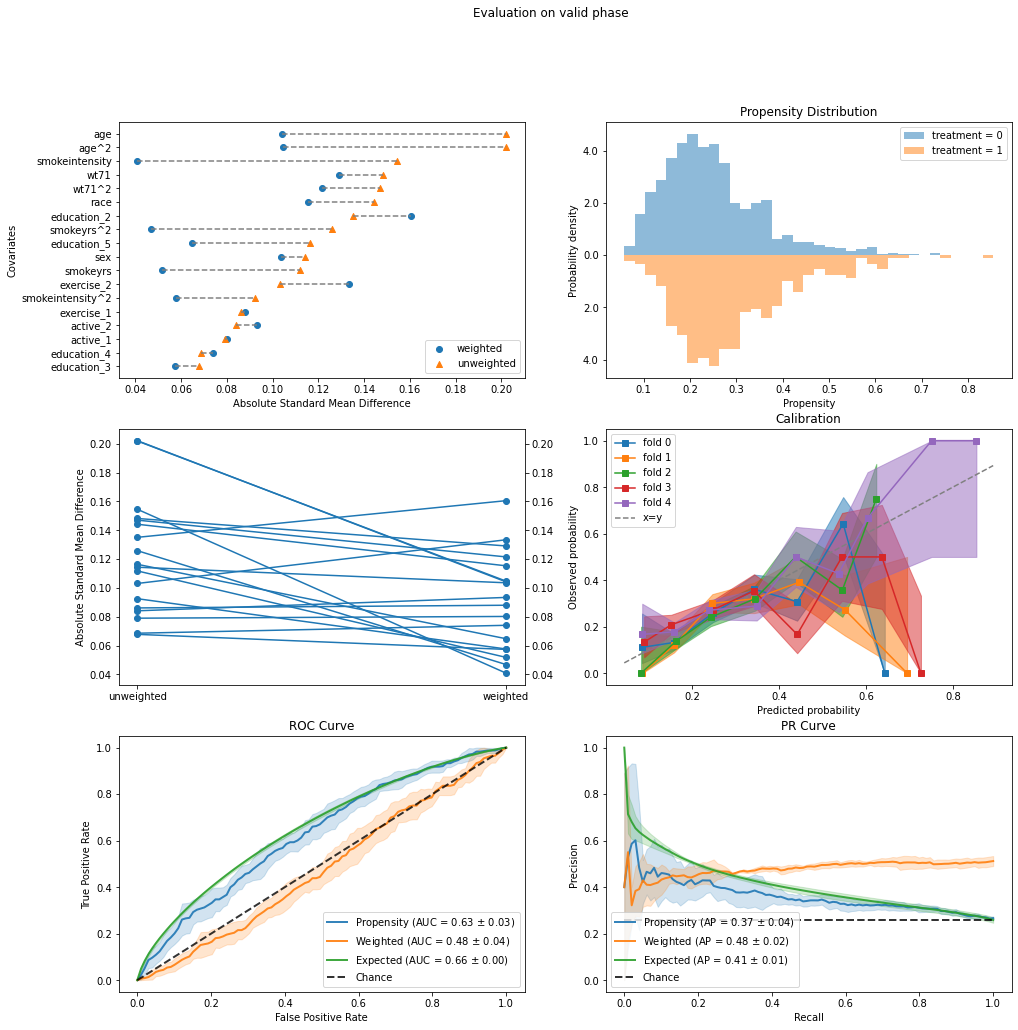

In [17]:
prop_results_cv = propensity_evaluator.evaluate_cv(
    data.X,
    data.a,
    data.y,
)
propensity_evaluator.plotter.plot_cv(
    X=data.X,
    a=data.a,
    y=data.y,
    plots=propensity_plots,
    predictions=prop_results_cv.predictions,
    cv=prop_results_cv.cv,
)

### Continuous outcome plots

{'train': {'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>,
  'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>},
 'valid': {'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>,
  'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>}}

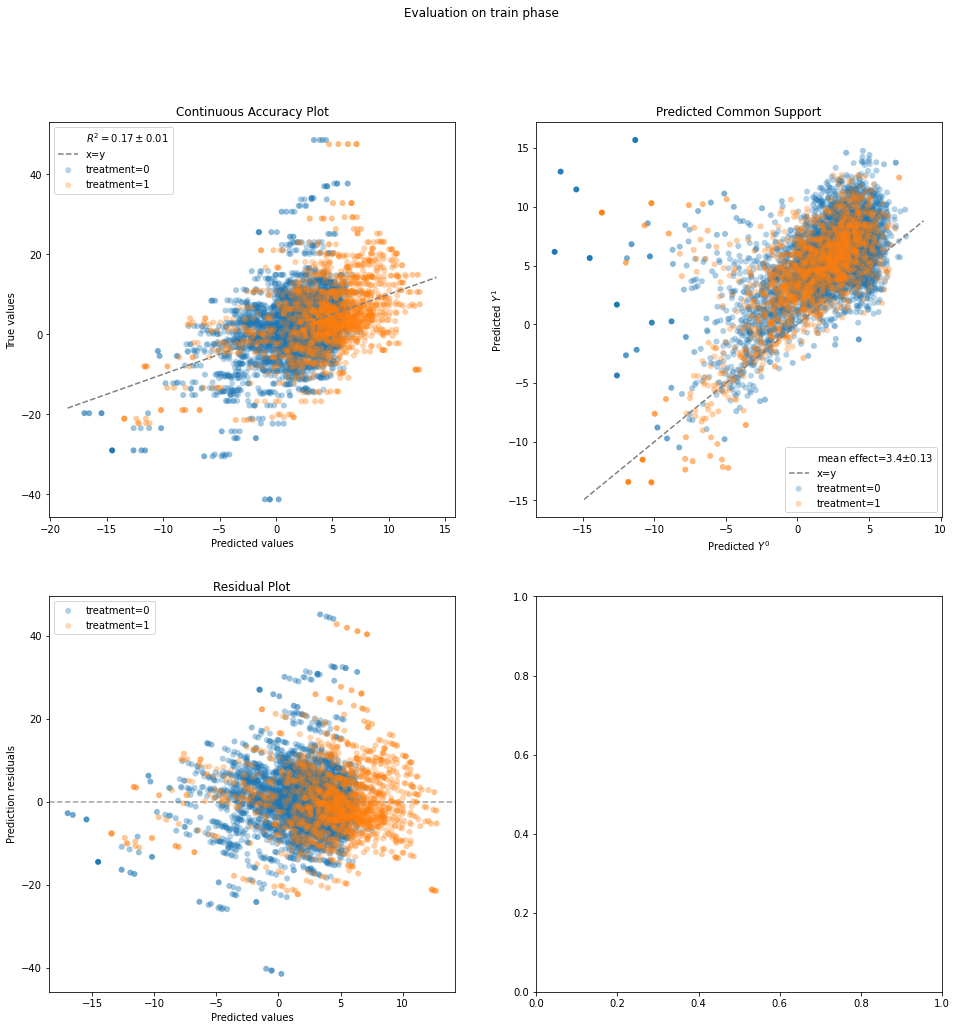

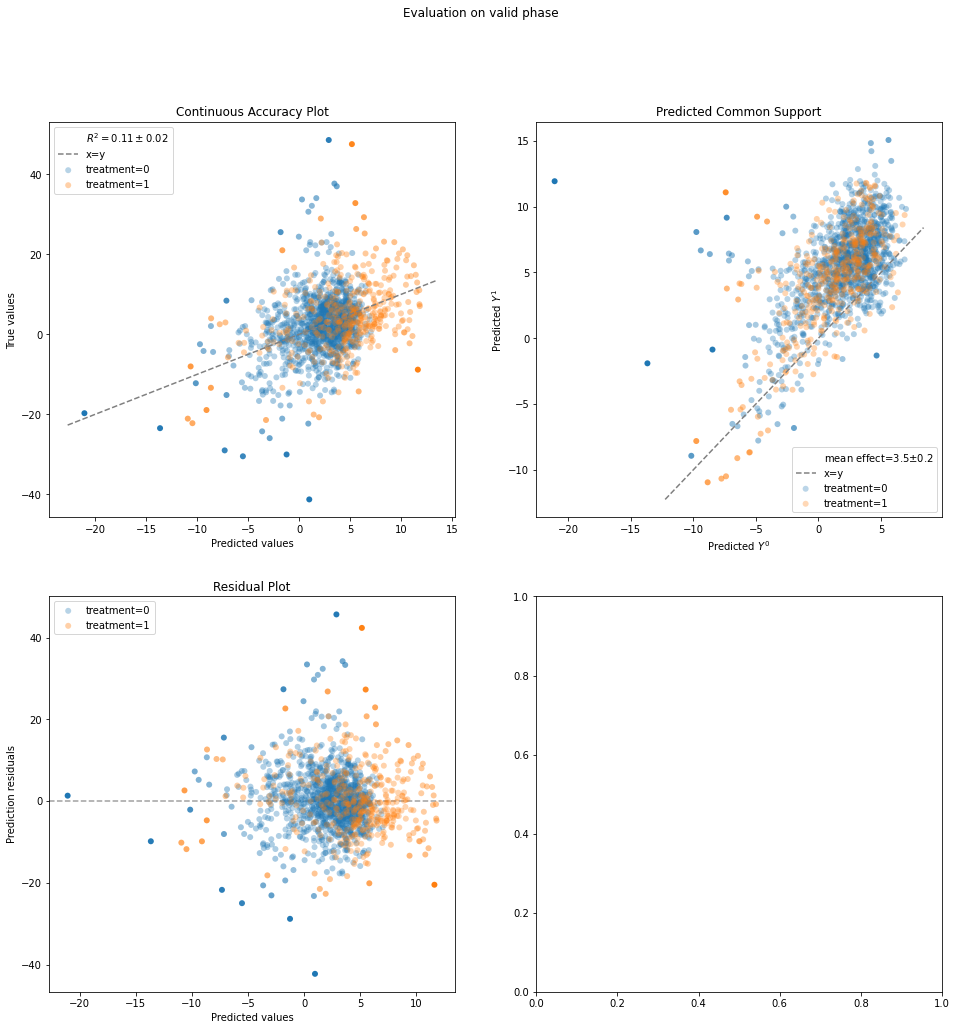

In [18]:
cont_outcome_cv_results = cont_outcome_evaluator.evaluate_cv(
    data.X,
    data.a,
    data.y,
)
cont_outcome_evaluator.plotter.plot_cv(
    X=data.X,
    a=data.a,
    y=data.y,
    predictions=cont_outcome_cv_results.predictions,
    plots=continuous_outcome_plots,
    cv=cont_outcome_cv_results.cv,
)

### Binary outcome plots

{'train': {'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>},
 'valid': {'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>}}

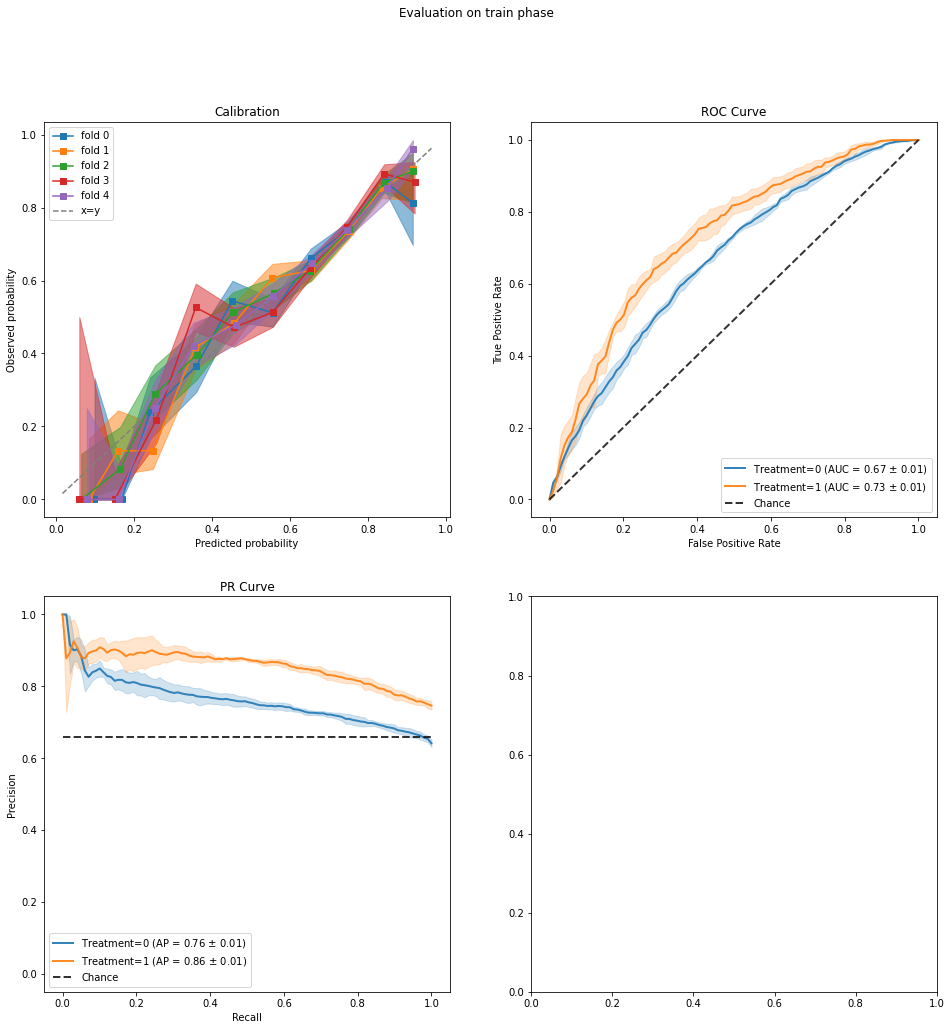

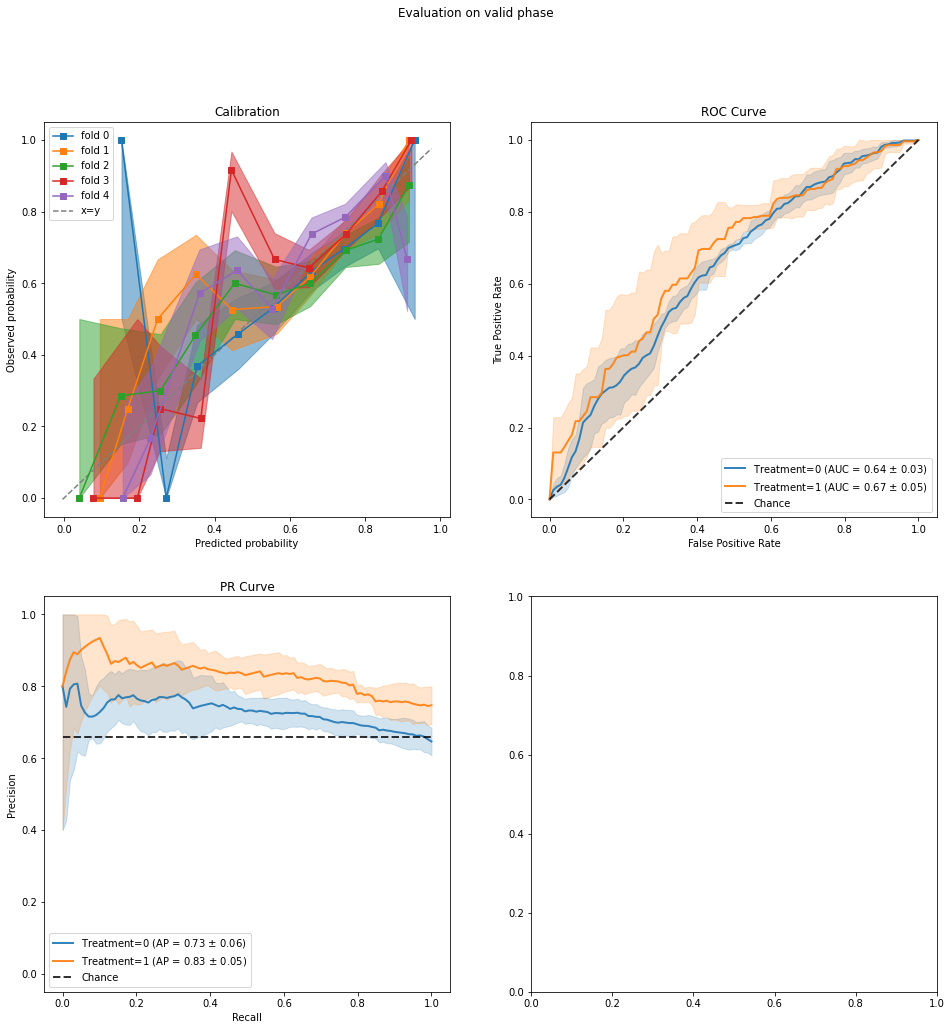

In [19]:
bin_outcome_cv_results = bin_outcome_evaluator.evaluate_cv(
    data.X,
    data.a,
    y,
    metrics_to_evaluate={},
)
bin_outcome_evaluator.plotter.plot_cv(
    X=data.X,
    a=data.a,
    y=y,
    predictions=bin_outcome_cv_results.predictions,
    cv=bin_outcome_cv_results.cv,
    plots=binary_outcome_plots,
)